In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from models.yolo_detector import YOLODetector
from models.resnet_classifier import ResNetClassifier
from models.trocr_ocr import TrOCROCR
from utils.image_processing import preprocess_image, updated_preprocess_image
from utils.box_sorting import sort_boxes

/opt/miniconda3/envs/medforcevenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#define the accelerator here
device = torch.device("mps" if torch.cuda.is_available() else "cpu") 

In [3]:
class OCRPipeline:
    def __init__(self):
        self.yolo_detector = YOLODetector()
        self.resnet_classifier = ResNetClassifier(device)
        self.trocr_ocr = TrOCROCR(device)

    def process_image(self, image_path, visualize=True):
        """Main OCR processing pipeline"""
        orig_image = Image.open(image_path).convert("RGB")
        img_with_boxes = orig_image.copy()

        #! Uncomment below if you want to visualize the input image.
        # if visualize:
        #     plt.figure(figsize=(12, 8))
        #     plt.imshow(orig_image)
        #     plt.title("Input Image", fontsize=16)
        #     plt.axis('off')
        #     plt.show()

        # Detect text regions with YOLO
        all_boxes = self.yolo_detector.detect_text(orig_image)
        # sorted_boxes = sort_boxes(all_boxes)
        #! Here the boxes needs to be sorted later.
        # sorted_boxes = all_boxes
        sorted_boxes = [box for sublist in all_boxes for box in sublist]


        final_text = []
        classification_results = []
        draw = ImageDraw.Draw(img_with_boxes)

        for box in sorted_boxes:
            x1, y1, x2, y2 = map(int, box)
            cropped_region = orig_image.crop((x1, y1, x2, y2))

            # Show cropped text region before preprocessing
            plt.figure(figsize=(4, 4))
            plt.imshow(cropped_region)
            plt.title("Cropped Text Region", fontsize=12)
            plt.axis('off')
            plt.show()

            classifier_input = updated_preprocess_image(cropped_region)

            # Show preprocessed image
            plt.figure(figsize=(4, 4))
            plt.imshow(classifier_input, cmap="gray")
            plt.title("Preprocessed Image", fontsize=12)
            plt.axis('off')
            plt.show()

            class_id, confidence = self.resnet_classifier.classify(classifier_input)
            classification_results.append((x1, y1, x2, y2, class_id, confidence))

            # if class_id == 0:
                # ocr_text = self.trocr_ocr.recognize_text(cropped_region)
                # final_text.append(ocr_text)

        # Visualization
        if visualize:
            for x1, y1, x2, y2, class_id, conf in classification_results:
                color = "green" if class_id == 0 else "red"
                label = f"{'Text' if class_id == 0 else 'Strike'} ({conf:.2f})"
                draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
                draw.text((x1+5, y1-25), label, fill=color)

            plt.figure(figsize=(16, 12))
            plt.imshow(img_with_boxes)
            plt.title("OCR Results - Green: Valid Text, Red: Strike-through", fontsize=18, pad=20)
            plt.axis('off')
            plt.show()

        # return ' '.join(final_text)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod


0: 192x640 30 words, 90.2ms
Speed: 14.1ms preprocess, 90.2ms inference, 14.2ms postprocess per image at shape (1, 3, 192, 640)


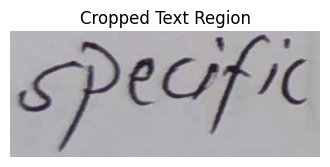

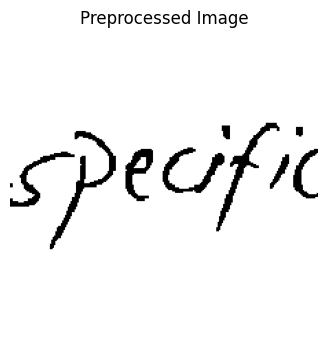

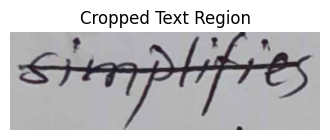

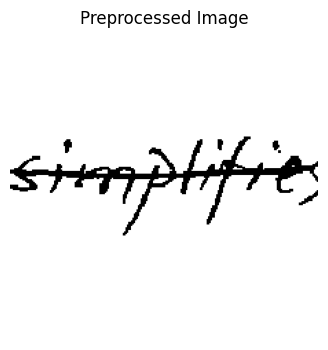

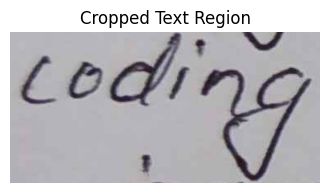

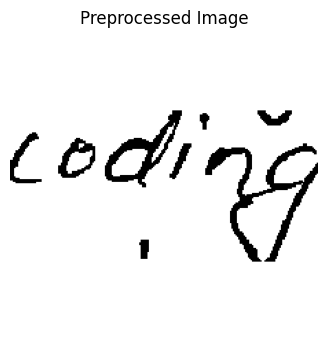

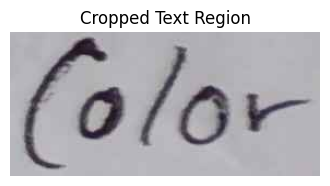

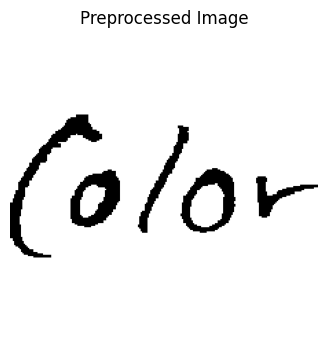

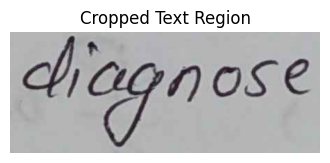

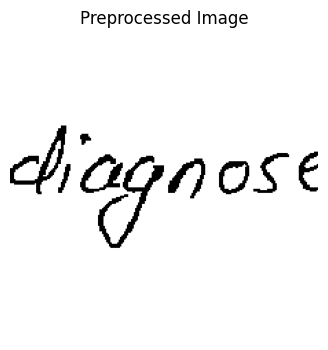

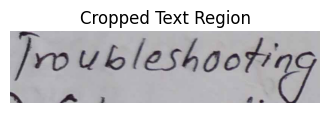

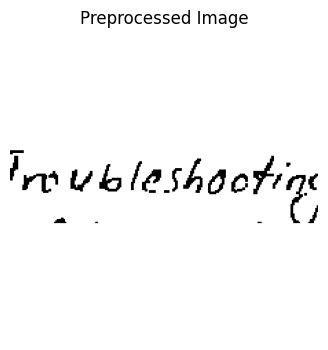

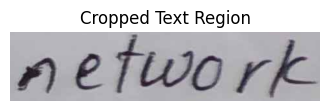

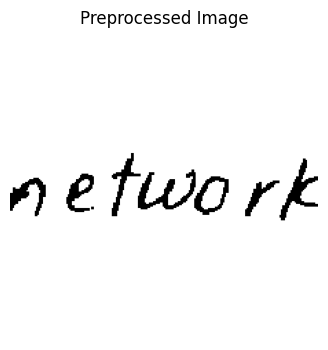

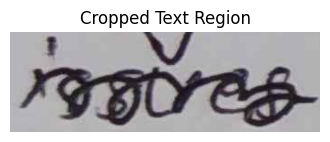

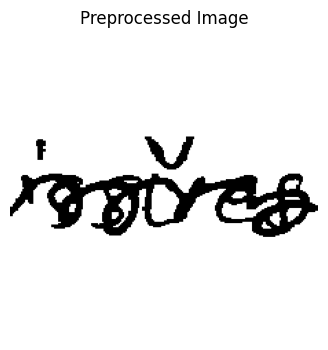

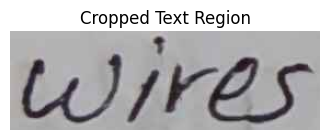

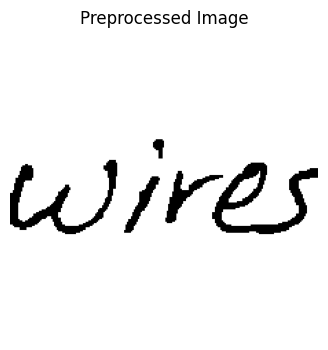

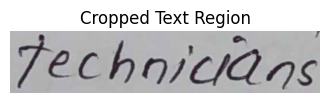

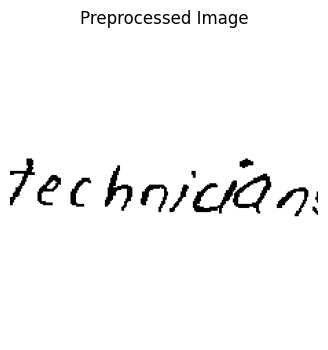

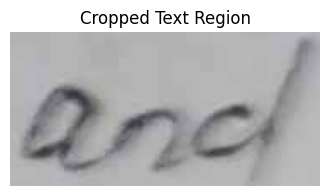

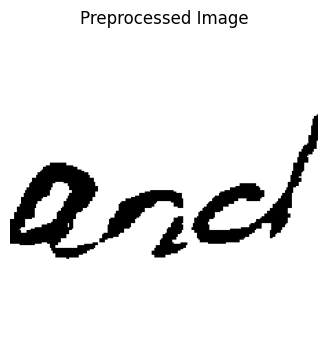

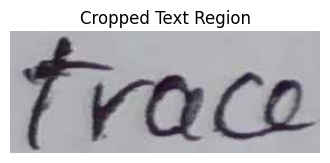

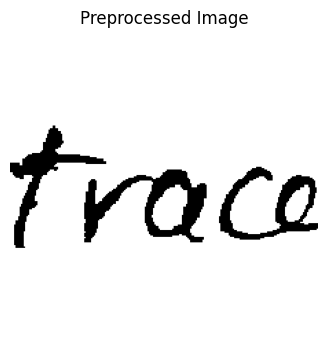

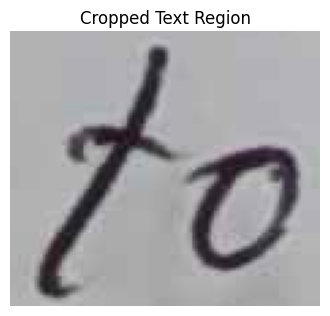

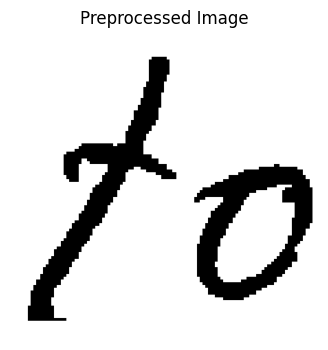

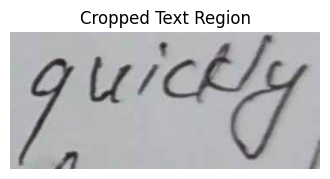

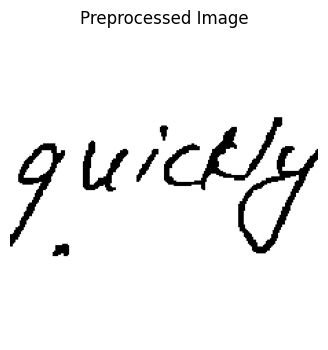

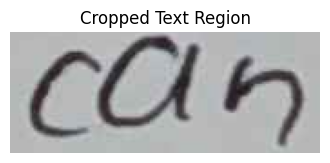

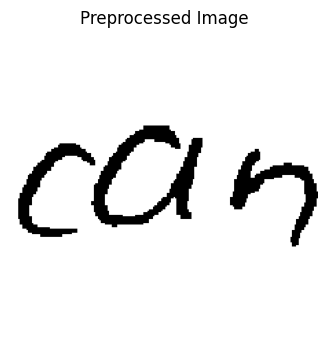

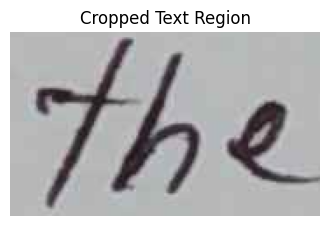

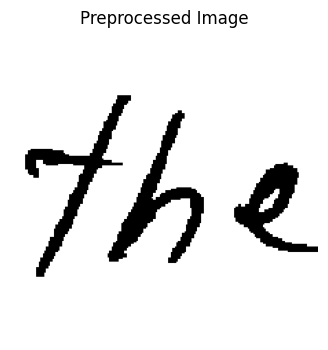

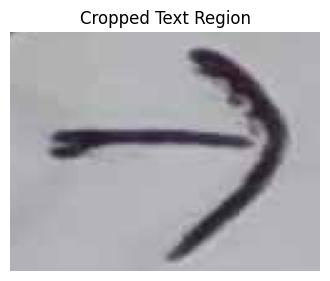

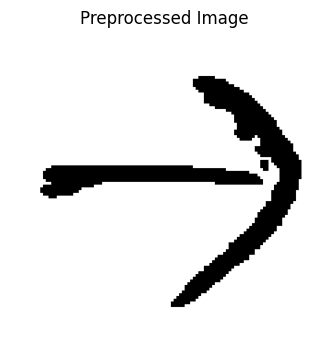

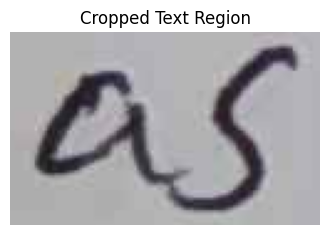

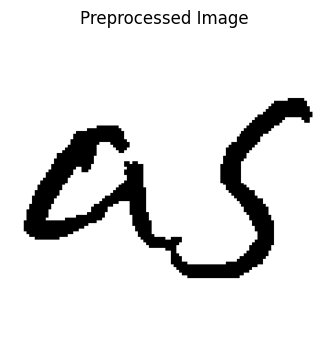

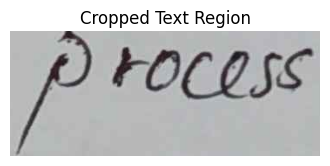

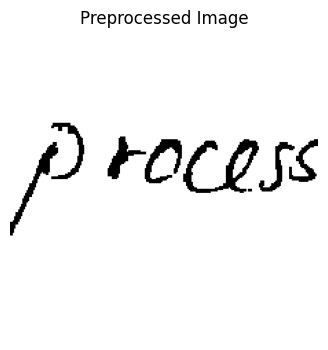

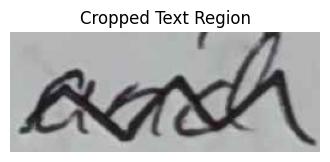

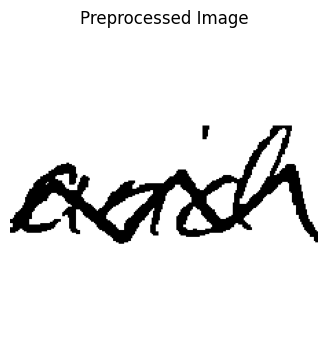

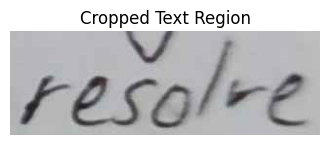

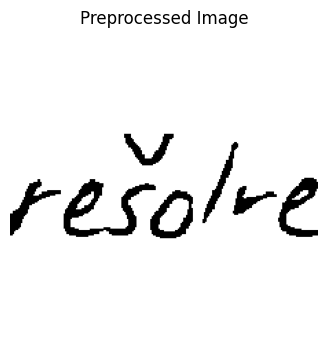

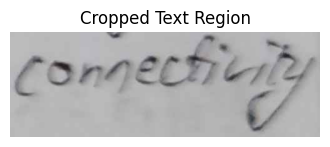

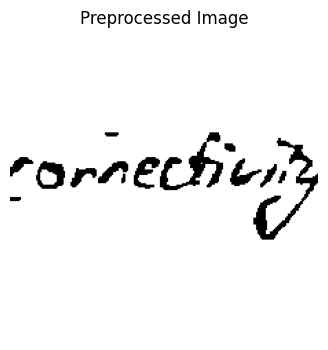

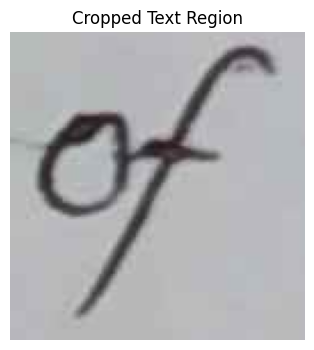

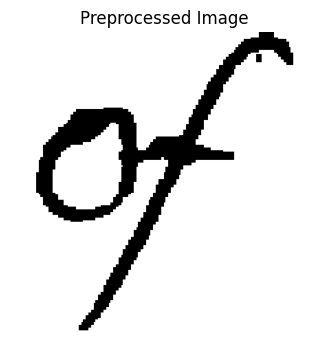

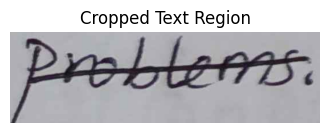

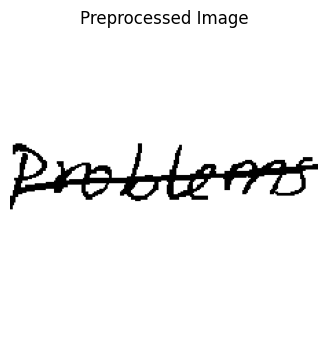

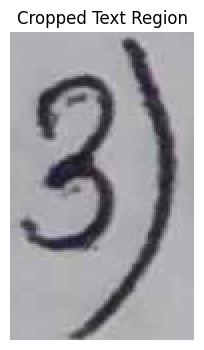

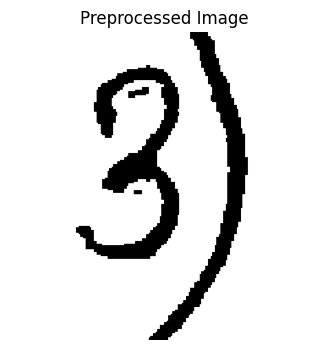

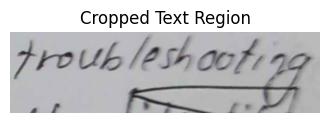

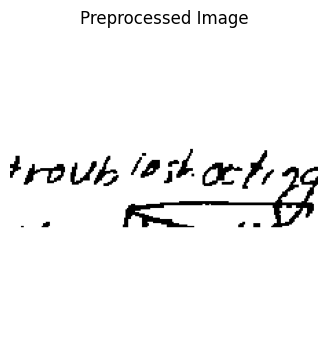

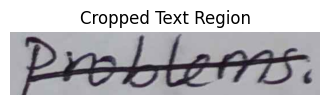

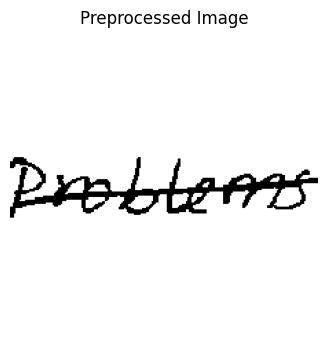

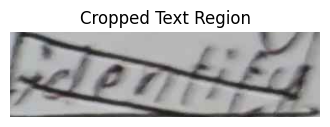

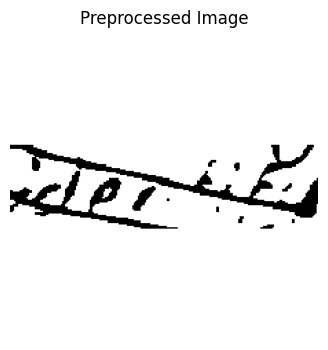

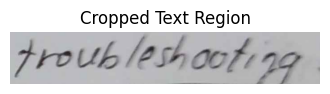

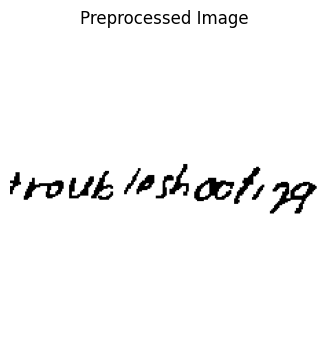

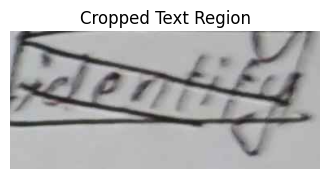

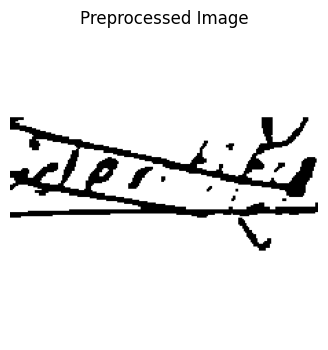

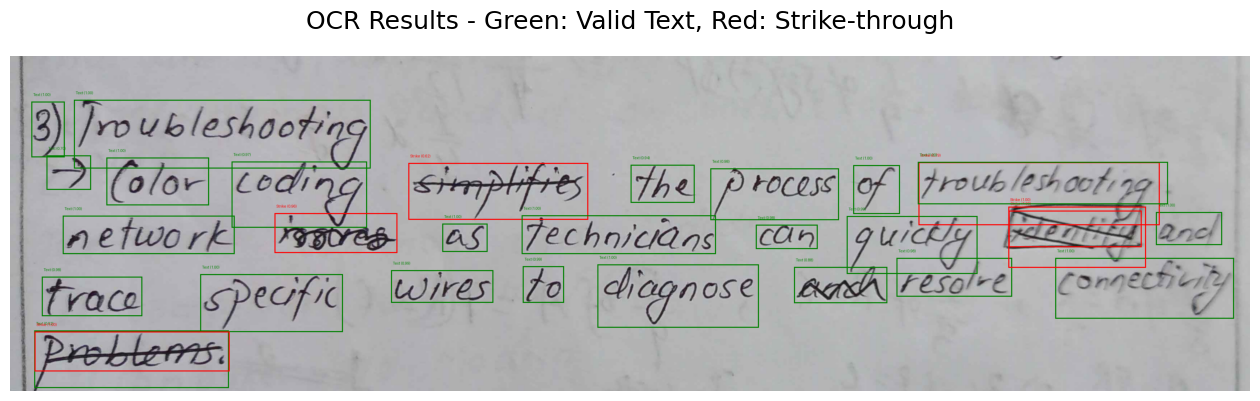

In [4]:
pipeline = OCRPipeline()
extracted_text = pipeline.process_image("test_images/try1.jpg")
# print("Extracted Text:", extracted_text)